# LSTM Well Log Prediction (Corrected Final Year Project Code)
This notebook fixes previous issues with proper sequence preparation, physics-informed loss, early stopping, and correct visualization.

In [127]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import optuna


In [245]:

# Load dataset
df = pd.read_csv('cleaned_well_data.csv')
depth = df['DEPT'].values

# Features and target
input_features = ['GR', 'PHIE:1', 'VSH', 'RHOB:1', 'CALI', 'SP:1']
target_log = ['RES']

X = df[input_features].values
y = df[target_log].values

# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [276]:

# Create sequences for LSTM input
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Train-test split (80-20 split)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
depth_train, depth_test = depth[seq_length:split_idx+seq_length], depth[split_idx+seq_length:]


In [277]:

# Physics loss: smooth transitions in prediction along the depth
def physics_loss(y_true, y_pred):
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    smoothness = tf.reduce_mean(tf.square(y_pred[1:] - y_pred[:-1]))
    return data_loss + 0.2 * smoothness


In [278]:

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss=physics_loss, metrics=['mae'])
model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 30, 64)            18176     
                                                                 
 dropout_48 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_49 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [279]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')
]


In [280]:

history = model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)


Epoch 1/250
62/62 [==============================] - 12s 85ms/step - loss: 0.0037 - mae: 0.0299 - val_loss: 2.3635e-04 - val_mae: 0.0109
Epoch 2/250
62/62 [==============================] - 4s 59ms/step - loss: 0.0021 - mae: 0.0170 - val_loss: 1.3118e-04 - val_mae: 0.0059
Epoch 3/250
62/62 [==============================] - 3s 51ms/step - loss: 0.0020 - mae: 0.0157 - val_loss: 1.5370e-04 - val_mae: 0.0082
Epoch 4/250
62/62 [==============================] - 3s 49ms/step - loss: 0.0019 - mae: 0.0141 - val_loss: 1.4382e-04 - val_mae: 0.0061
Epoch 5/250
62/62 [==============================] - 3s 50ms/step - loss: 0.0019 - mae: 0.0141 - val_loss: 1.2779e-04 - val_mae: 0.0053
Epoch 6/250
62/62 [==============================] - 3s 53ms/step - loss: 0.0019 - mae: 0.0126 - val_loss: 1.1734e-04 - val_mae: 0.0050
Epoch 7/250
62/62 [==============================] - 3s 54ms/step - loss: 0.0018 - mae: 0.0128 - val_loss: 1.2040e-04 - val_mae: 0.0052
Epoch 8/250
62/62 [============================

In [281]:

y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)
depth_test = np.array(depth_test)


31/31 [==============================] - 4s 14ms/step


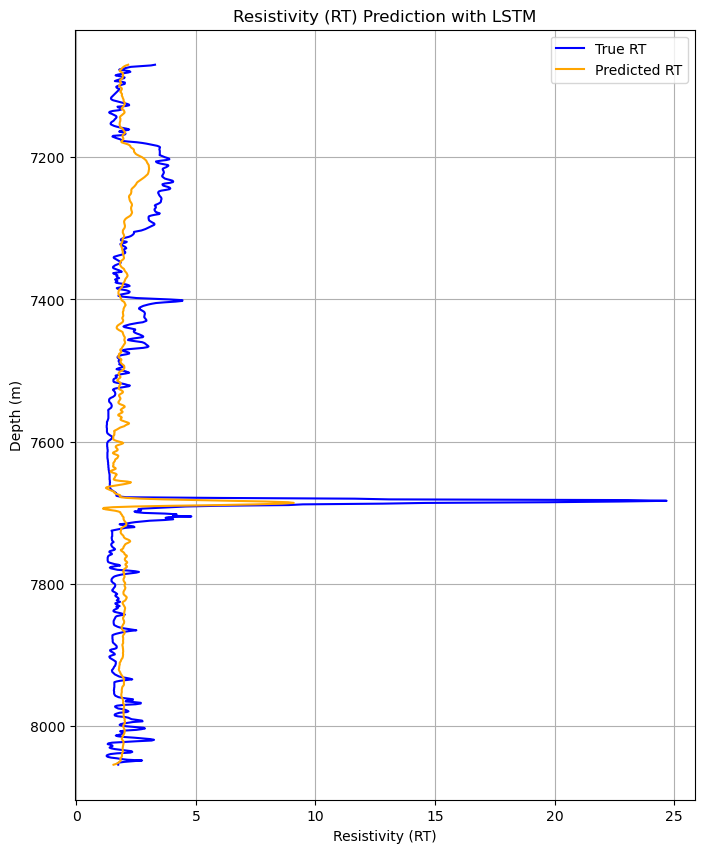

In [282]:

plt.figure(figsize=(8, 10))
plt.plot(y_test_rescaled, depth_test, label='True RT', color='blue')
plt.plot(y_pred_rescaled, depth_test, label='Predicted RT', color='orange')
plt.gca().invert_yaxis()
plt.xlabel('Resistivity (RT)')
plt.ylabel('Depth (m)')
plt.title('Resistivity (RT) Prediction with LSTM')
plt.legend()
plt.grid(True)
plt.show()


In [283]:
model.save('final_lstm_well_log_model.h5')

In [284]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100
accuracy = 100 - mape
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Prediction Accuracy (100 - MAPE): {accuracy:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

Prediction Accuracy (100 - MAPE): 77.40%
Mean Absolute Percentage Error (MAPE): 22.60%
R² Score: 0.4257


In [285]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 1.6486
